<a href="https://colab.research.google.com/github/tbilach13/Analysis_Police_Killings/blob/master/Bilach__Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/the-counted-2015.csv", encoding = "ISO-8859-1")
deaths = df.copy();

# Does the semi-colon always remove messages?

In [0]:
deaths.head()

# Analysis of Police Killings

The analysis will assess the correlates of police killings in the United States. I will endeavor to investiate the following:

* The demographic composition of decedents;
* The threats imposed to officers at the time of the person's death;
* Do crime rates or population density predict your likelihood of being killed by the police?

## Escape Characters

The Counted is the most thorough public accounting for deadly use of force in the US

The FBI runs a voluntary program through which law enforcement agencies may or may not choose to submit their annual count of “justifiable homicides”, which it defines as “the killing of a felon in the line of duty”.

This system is arguably less valuable than having no system at all: fluctuations in the number of agencies choosing to report figures, plus faulty reporting by agencies that do report, have resulted in partially informed news coverage pointing misleadingly to trends that may or may not exist.

Between 2005 and 2012 just 1,100 police departments – a fraction of America’s 18,000 police agencies – reported a “justifiable homicide” to the FBI.

The FBI system counted 461 justifiable homicides by law enforcement in 2013, the latest year for which data is available. Crowdsourced counts found almost 300 additional fatalities during that year. The Counted, upon its launch on June 1, 2015, had already found close to that number of killings in just the first five months of 2015.

Any deaths arising directly from encounters with law enforcement. This will inevitably include, but will likely not be limited to, people who were shot, tasered and struck by police vehicles as well those who died in police custody. 

You can find more information at [The Guardian's](https://www.theguardian.com/us-news/ng-interactive/2015/jun/01/about-the-counted) webpage.

In [11]:
deaths.rename(columns = {'name'                 : 'decedent_name',
                         'raceethnicity'        : 'race_ethn',
                         'streetaddress'        : 'str_add',
                         'lawenforcementagency' : 'agency_name'
                         }, inplace = True)

deaths['age'] = deaths['age'].replace('Unknown', np.nan).apply(float)

# Combining dropping the 'non-conforming' category

def flag_non_conforming(df):
  if df['gender'] == 'Non-conforming':
    return np.nan
  else:
    return df['gender']

deaths['gender'] = deaths.apply(flag_non_conforming, axis = 1)

# Combining race/ethnic categories

def flag_comb_race_cat(df):
  if (df['race_ethn'] == 'Arab-American' or df['race_ethn'] == 'Native American' or df['race_ethn'] == 'Other' or df['race_ethn'] == 'Unknown'):
    return 'Other'
  else:
    return df['race_ethn']

deaths['race_ethn'] = deaths.apply(flag_comb_race_cat, axis = 1)
deaths['race_ethn'] = deaths['race_ethn'].astype('category')
deaths['race_ethn'].cat.reorder_categories(['White', 
                                            'Black', 
                                            'Hispanic/Latino', 
                                            'Asian/Pacific Islander',
                                            'Other'], inplace = True)

deaths['month'] = deaths['month'].astype('category')
deaths['month'].cat.reorder_categories(['January', 
                                        'February', 
                                        'March', 
                                        'April', 
                                        'May', 
                                        'June', 
                                        'July', 
                                        'August', 
                                        'September', 
                                        'October', 
                                        'November', 
                                        'December'], 
                                       inplace = True)
deaths.armed.unique()

array(['No', 'Firearm', 'Non-lethal firearm', 'Other', 'Knife', 'Vehicle',
       'Unknown', 'Disputed'], dtype=object)

In [16]:
deaths[['decedent_name', 'age', 'gender', 'race_ethn', 'month', 'day', 'city', 'state', 'armed']].head(10)

,decedent_name,age,gender,race_ethn,month,day,city,state,armed
0,Matthew Ajibade,22.0,Male,Black,January,1,Savannah,GA,No
1,Lewis Lembke,47.0,Male,White,January,2,Aloha,OR,Firearm
2,Michael Kocher Jr,19.0,Male,White,January,3,Kaumakani,HI,No
3,John Quintero,23.0,Male,Hispanic/Latino,January,3,Wichita,KS,No
4,Tim Elliott,53.0,Male,Asian/Pacific Islander,January,2,Shelton,WA,Firearm
5,Matthew Hoffman,32.0,Male,White,January,4,San Francisco,CA,Non-lethal firearm
6,Kenneth Buck,22.0,Male,Hispanic/Latino,January,5,Chandler,AZ,Firearm
7,Michael Rodriguez,39.0,Male,Hispanic/Latino,January,5,Evans,CO,Other
8,Patrick Wetter,25.0,Male,White,January,6,Stockton,CA,Knife
9,Brian Pickett,26.0,Male,Black,January,6,Los Angeles,CA,No


In [26]:
# The suspect displays "any weapon" to the officer.

def flag_any_weapon(df):
  if (df['armed'] == 'No' or df['armed'] == 'Unknown' or df['armed'] == 'Disputed'):
    return 0
  else:
    return 1

deaths['any_weapon'] = deaths.apply(flag_any_weapon, axis = 1)

# The suspect displays a "gun (or toy gun)" to the officer.

def flag_gun(df):
  if (df['armed'] == 'Firearm' or df['armed'] == 'Non-lethal firearm'):
    return 1
  else:
    return 0

deaths['gun_displayed'] = deaths.apply(flag_gun, axis = 1)

# The suspect displays a "knife" to the officer.

def flag_knife(df):
  if (df['armed'] == 'Knife'):
    return 1
  else:
    return 0

deaths['knife_displayed'] = deaths.apply(flag_knife, axis = 1)

# The suspect was "unarmed (included unknown)" at the time of death.

def flag_unarmed(df):
  if (df['armed'] == 'No' or df['armed'] == 'Unknown'):
    return 1
  else:
    return 0

deaths['unarmed'] = deaths.apply(flag_unarmed, axis = 1)

deaths.loc[:,"armed"].unique()
deaths.loc[:,"gender"].unique()

array(['Male', 'Female', nan], dtype=object)

In [27]:
deaths.dropna(subset = ['gender'])

race_sex = pd.crosstab(index = deaths["race_ethn"], 
                       columns = deaths["gender"],
                       margins = True,
                       colnames = ['Gender:'],
                       rownames = ["Race/Ethnicity"])
race_sex

Gender:,Female,Male,All
Race/Ethnicity,,,
White,34,550,584
Black,12,295,307
Hispanic/Latino,3,191,194
Asian/Pacific Islander,2,22,24
Other,1,35,36
All,52,1093,1145


In [28]:
deaths.head()

,uid,decedent_name,age,gender,race_ethn,month,day,year,str_add,city,state,classification,agency_name,armed,any_weapon,gun_displayed,knife_displayed,unarmed
0,2,Matthew Ajibade,22.0,Male,Black,January,1,2015,1050 Carl Griffin Dr,Savannah,GA,Death in custody,Chatham County Sheriff's Office,No,0,0,0,1
1,4,Lewis Lembke,47.0,Male,White,January,2,2015,4505 SW Masters Loop,Aloha,OR,Gunshot,Washington County Sheriff's Office,Firearm,1,1,0,0
2,5,Michael Kocher Jr,19.0,Male,White,January,3,2015,2600 Kaumualii Hwy,Kaumakani,HI,Struck by vehicle,Kauai Police Department,No,0,0,0,1
3,6,John Quintero,23.0,Male,Hispanic/Latino,January,3,2015,500 North Oliver Ave,Wichita,KS,Gunshot,Wichita Police Department,No,0,0,0,1
4,7,Tim Elliott,53.0,Male,Asian/Pacific Islander,January,2,2015,600 E Island Lake Dr,Shelton,WA,Gunshot,Mason County Sheriff's Office,Firearm,1,1,0,0


In [29]:
state_by_age = deaths[['gender', 'age']]
state_by_age.groupby('gender')['age'].mean()
deaths.groupby('armed')['knife_displayed'].mean()

armed
Disputed              0
Firearm               0
Knife                 1
No                    0
Non-lethal firearm    0
Other                 0
Unknown               0
Vehicle               0
Name: knife_displayed, dtype: int64

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


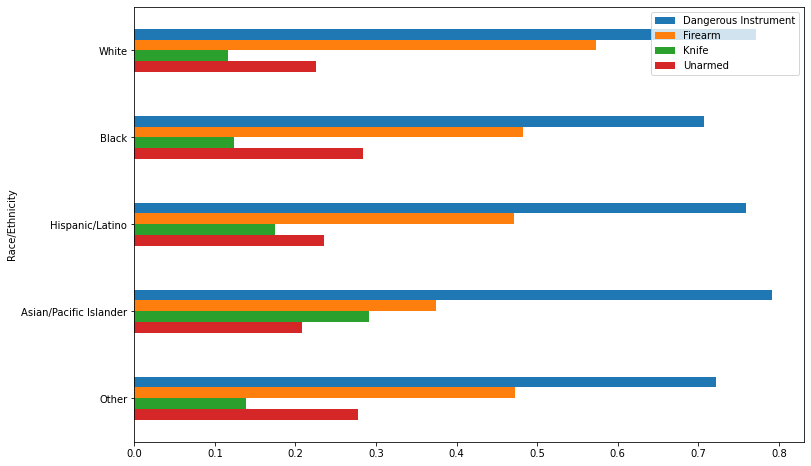

In [31]:
threat_types = deaths[["race_ethn", "any_weapon", "gun_displayed", "knife_displayed", "unarmed"]]

threat_types.rename(columns = {'race_ethn'       : 'Race/Ethnicity',
                               'any_weapon'      : 'Dangerous Instrument',
                               'gun_displayed'   : 'Firearm',
                               'knife_displayed' : 'Knife',
                               'unarmed'         : 'Unarmed'
                               }, inplace = True)

threat_types.groupby('Race/Ethnicity').mean().plot(kind = "barh", figsize = (12, 8)).invert_yaxis();

In [7]:
plot_state_count = state_by_age.groupby('state')['state'].count().sort_values(ascending = False).head(10)
plot_state_count.head()

# The top 3 in each city

#state_city = deaths.groupby(['state', 'city'])['city'].count().sort_values(ascending = False).head(10)
#state_city
# subset_count.groupby('state')['state'].count().sort_values(ascending = False).head(10)
# deaths.sort_values(['state', 'city'], ascending = True).groupby('job').head(3)

NameError: ignored

In [25]:
plot_state_count = deaths.groupby(['state', 'city']).city.agg('count').to_frame('count').reset_index()

# There are 121

state_and_city = plot_state_count.sort_values(by = "count", ascending = False).head(20)
#state_and_city.groupby("state")['state'].count().sort_values(ascending = False)

state
CA    5
TX    4
FL    2
OK    1
OH    1
NY    1
NV    1
IN    1
IL    1
DC    1
CO    1
AZ    1
Name: state, dtype: int64

Text(0, 0.5, 'Density')

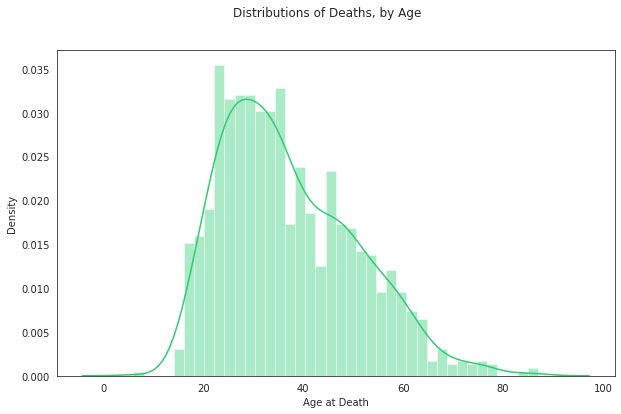

In [7]:
sns.set_style("white")
dims = (10, 6)
fig, ax = plt.subplots(figsize = (dims))
fig.suptitle('Distributions of Deaths, by Age')
sns.distplot(deaths['age'], label = deaths['gender'], bins = 40, hist = True, kde = True, color = '#2ecc71', ax = ax)
plt.xlabel("Age at Death")
plt.ylabel("Density")

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


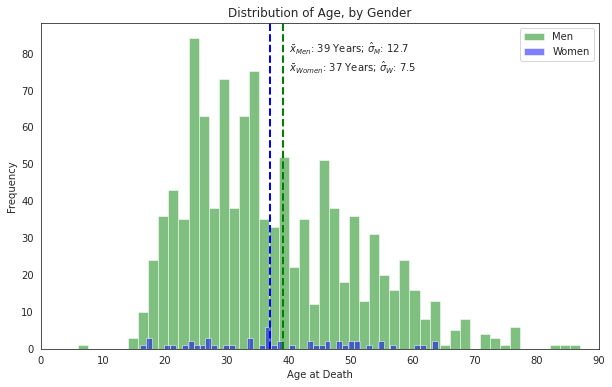

In [69]:
sns.set_style("white")
dims = (10, 6)
fig, ax = plt.subplots(figsize = (dims))
x1 = deaths.loc[deaths.gender == 'Male', 'age']
x2 = deaths.loc[deaths.gender == 'Female', 'age']
kwargs = dict(alpha = 0.5, bins = 50)
plt.hist(x1, **kwargs, color = 'g', label = 'Men')
plt.hist(x2, **kwargs, color = 'b', label = 'Women')
plt.gca().set(title = 'Distribution of Age, by Gender', ylabel = 'Frequency')
plt.axvline(39, color = 'g', linestyle = 'dashed', linewidth = 2)
plt.axvline(37, color = 'b', linestyle = 'dashed', linewidth = 2)
plt.text(40, 80, r'$\bar{x}_{Men}$: 39 Years; $\hat{\sigma}_{M}$: 12.7')
plt.text(40, 75, r'$\bar{x}_{Women}$: 37 Years; $\hat{\sigma}_{W}$: 7.5')
plt.xlabel("Age at Death")
plt.xlim(0, 90)
plt.legend();

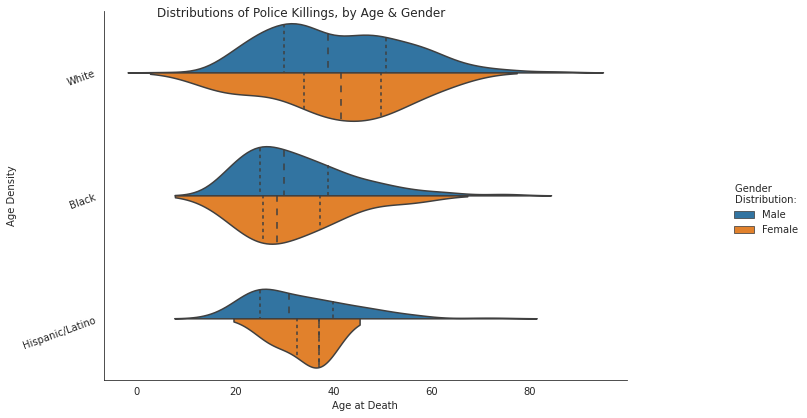

In [64]:
sns.set_style("white")
p = sns.catplot(x = "age", 
                y = "race_ethn", 
                kind = "violin", 
                hue = "gender", 
                split = True,
                order = ["White", "Black", "Hispanic/Latino"], 
                inner = "quartile", data = deaths)
p.fig.suptitle('Distributions of Police Killings, by Age & Gender')
p._legend.set_title("Gender \nDistribution:")
p.set_yticklabels(rotation = 20)
p.set(xlabel = 'Age at Death', ylabel = 'Age Density')
p.fig.set_size_inches(14, 6)

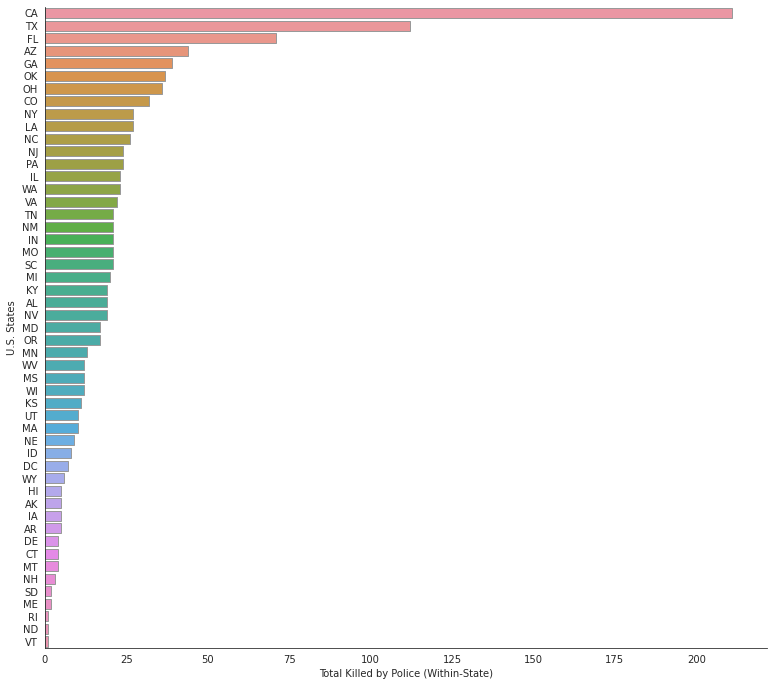

In [102]:
sns.set_style("white")
p2 = sns.catplot(y = "state", kind = "count", edgecolor = ".6", order = deaths["state"].value_counts().index, data = deaths)
p2.fig.set_size_inches(12, 10)
p2.set(xlabel = 'Total Killed by Police (Within-State)', ylabel = 'U.S. States');

In [0]:
sns.set_style("white")
p2 = sns.catplot(y = "agency_name", kind = "count", edgecolor = ".6", order = deaths["agency_name"].value_counts().index, data = deaths)
p2.fig.set_size_inches(12, 10);

In [101]:
deaths.groupby('agency_name')['agency_name'].count().sort_values(ascending = False).head(20)
 # Group by State and Agency, then count the number of agencies in each state.

agency_name
Los Angeles Police Department                  22
Los Angeles County Sheriff's Department        16
Houston Police Department                      11
New York Police Department                     10
Chicago Police Department                      10
Las Vegas Metropolitan Police Department        9
Indianapolis Metropolitan Police Department     9
Oklahoma City Police Department                 8
Phoenix Police Department                       8
San Francisco Police Department                 8
Austin Police Department                        8
Miami-Dade Police Department                    7
Dallas Police Department                        7
Riverside County Sheriff's Department           7
San Diego Police Department                     7
Jacksonville Sheriff's Office                   6
Bakersfield Police Department                   6
Pennsylvania State Police                       6
San Jose Police Department                      6
San Antonio Police Department         